<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter9DigitalImaging/panoramicFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Panoramic Image Fusion
## David Brady
## University of Arizona
## Spring 2023

This notebook illustrates keypoint identification and matching in image pairs. We also illustrate the use of keypoint pairs to determine homography between images and the use of homography to warp images to common viewpoint.

### load libraries and images

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import erf
from skimage import data, filters
from scipy import ndimage
from google.colab import files

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

## Image stitching with homographic transformation

Text(0.5, 0, 'image 2')

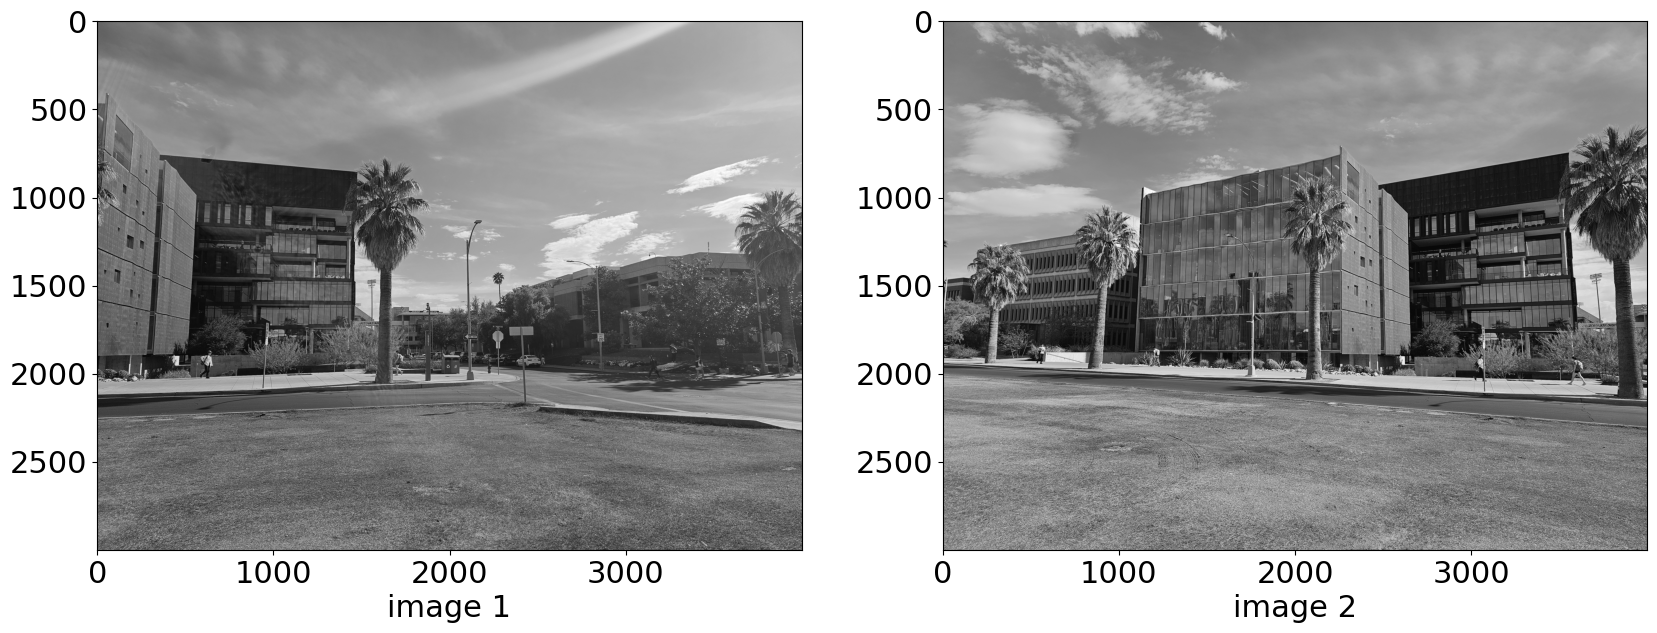

In [3]:
# Read the images
image1 = cv2.imread('image1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
#image1=image1[750:2750,:,:]
image2 = cv2.imread('image2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
#image2=image2[750:2750,:,:]
img1 =cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
img2 =cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.xlabel('image 1')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.xlabel('image 2')

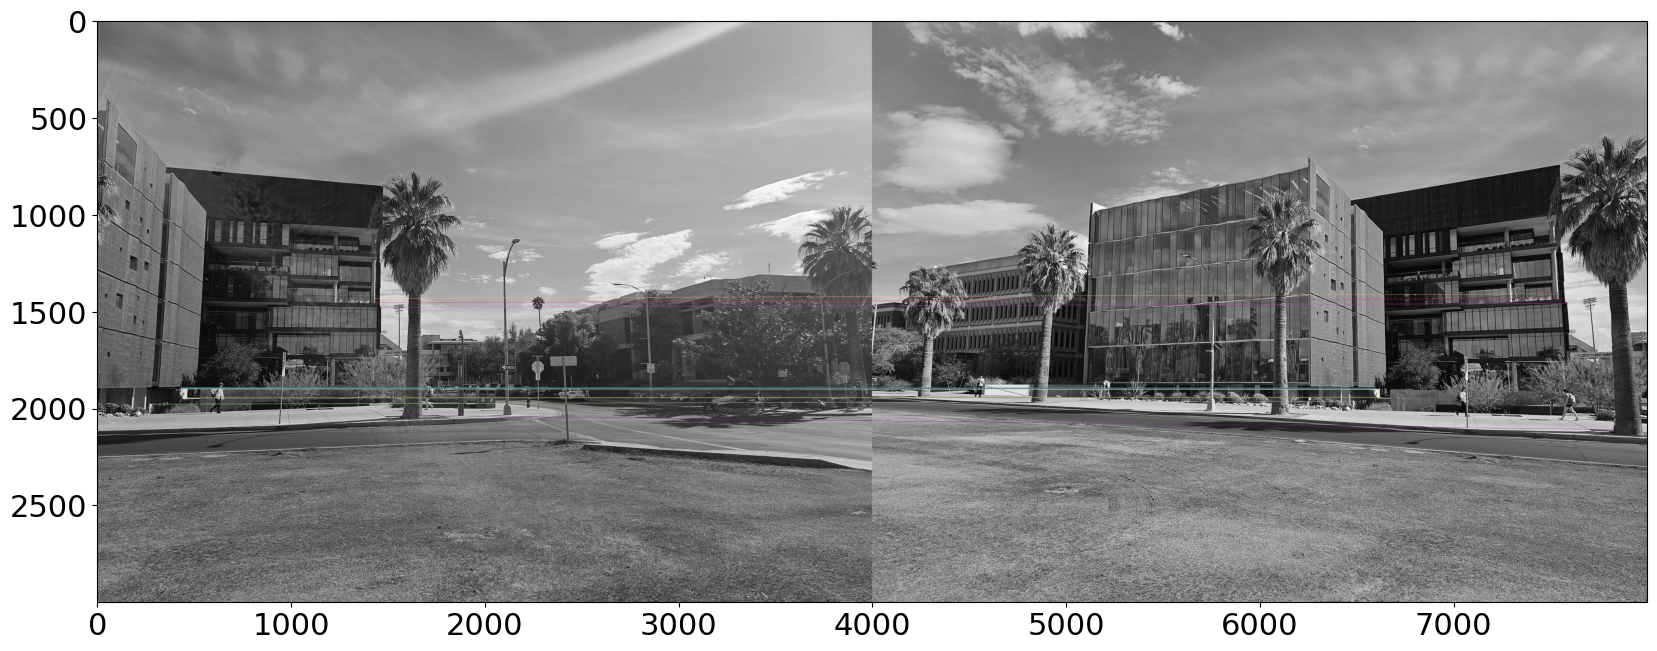

In [4]:
# Creating an ORB object
orb = cv2.ORB_create()

# Finding the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Creating a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Matching the descriptors
matches = bf.match(des1, des2)

# Sorting the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Drawing the first 10 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Showing the result
plt.imshow( img3)

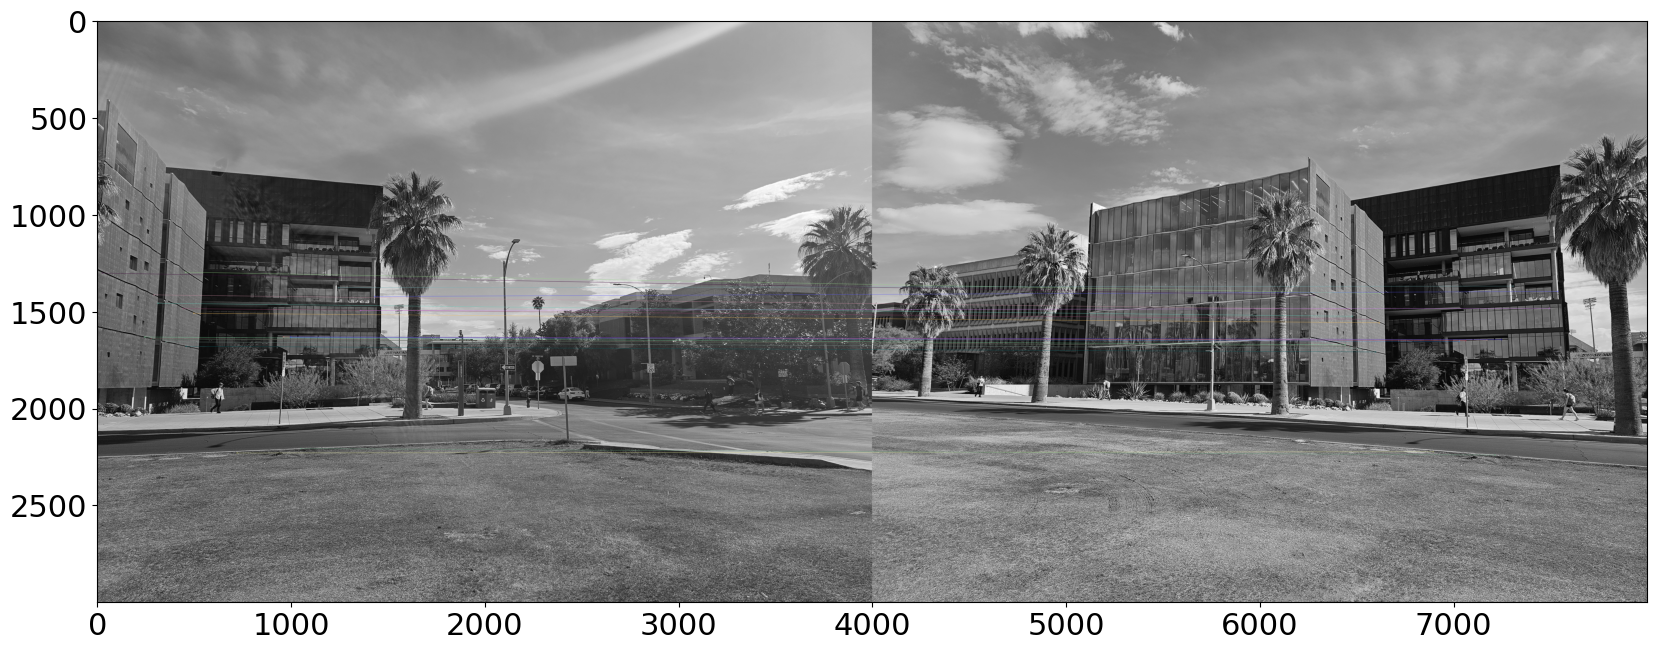

In [5]:
# Create a SIFT object
sift = cv2.SIFT_create(nfeatures = 0,edgeThreshold=6,contrastThreshold=0.1, nOctaveLayers=3,sigma=1.6)

# Detect and compute keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match the descriptors
matches = bf.match(des1, des2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw the first 20 matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the result
plt.imshow( img3)


In [6]:
# Define the FLANN matcher parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Create the FLANN matcher object
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Find the matches using KNN
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to filter the good matches
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Check if there are enough good matches
if len(good) > 10:
    # Extract the source and destination points from the good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Find the homography matrix using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Print the homography matrix
    print('Homography matrix:')
    print(H)
else:
    # Print an error message if not enough matches are found
    print('Not enough matches are found - {}/{}'.format(len(good), 10))

Homography matrix:
[[ 1.37413104e-01  5.01022435e-02  2.19026653e+03]
 [-3.75557792e-01  7.78674614e-01  4.01803635e+02]
 [-2.09989420e-04 -2.65880139e-06  1.00000000e+00]]


In [14]:
warpImage=cv2.warpPerspective(image1,H, (8000,3000))

In [13]:
image2.shape

(3000, 4000, 3)

Text(0.5, 0, 'image 2')

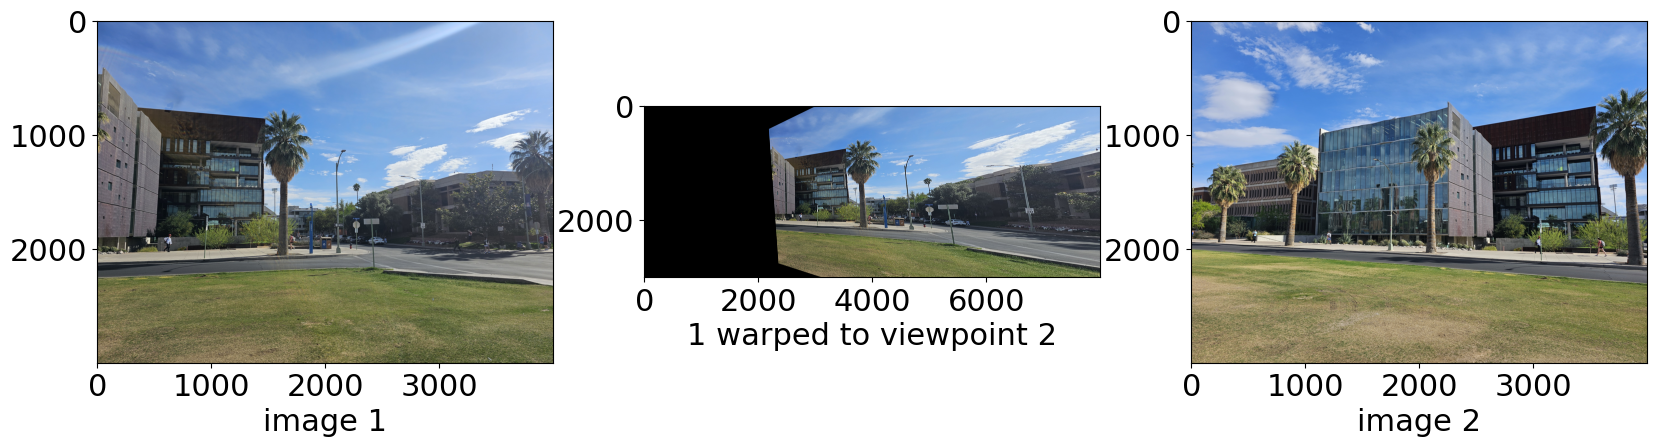

In [15]:
plt.subplot(1,3,1)
plt.imshow(image1)
plt.xlabel('image 1')
plt.subplot(1,3,2)
plt.imshow(warpImage)
plt.xlabel('1 warped to viewpoint 2')
plt.subplot(1,3,3)
plt.imshow(image2)
plt.xlabel('image 2')


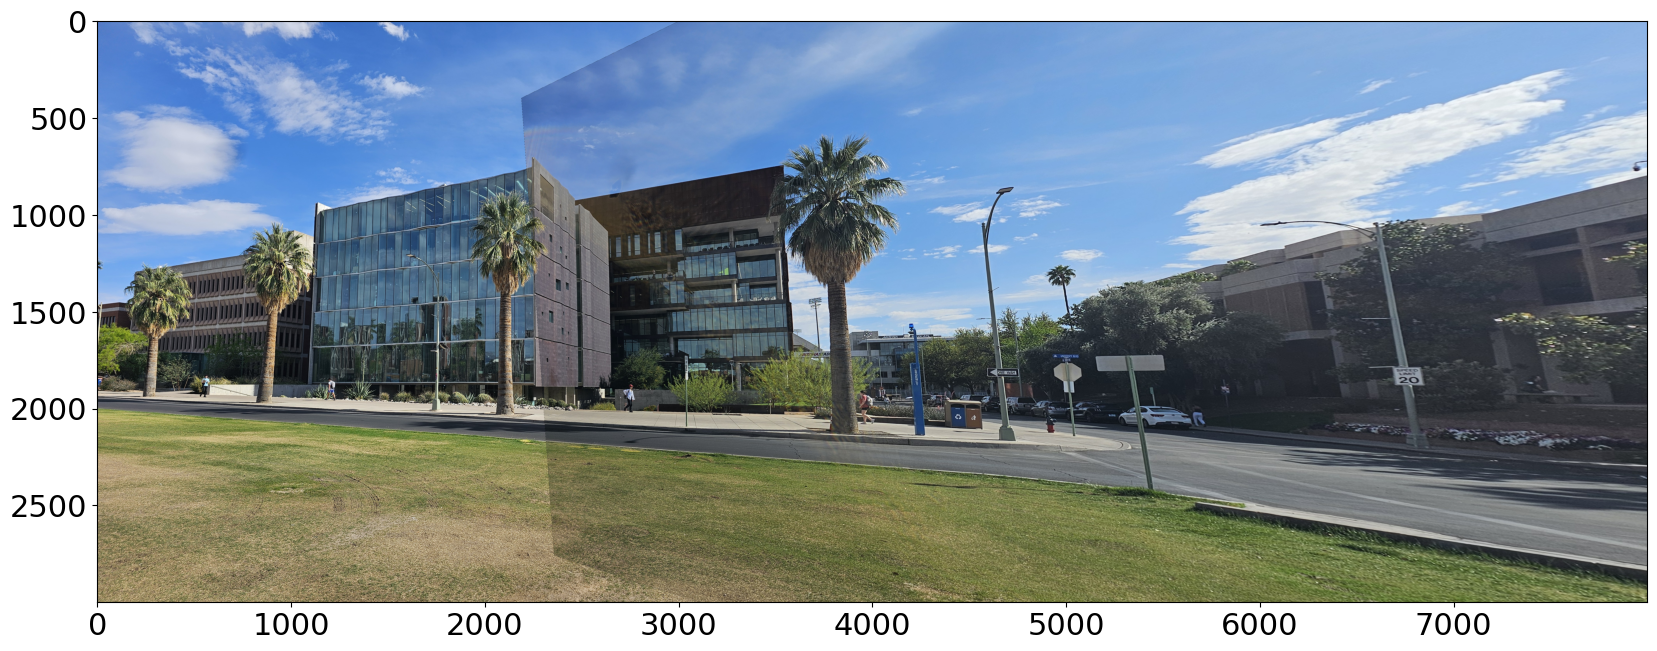

In [16]:
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        if warpImage[i,j,1] == 0:
            warpImage[i,j,:] = image2[i,j,:]
plt.imshow(warpImage)

## monochrome version

In [17]:
warpImage=cv2.warpPerspective(img1,H, (8000,3000))

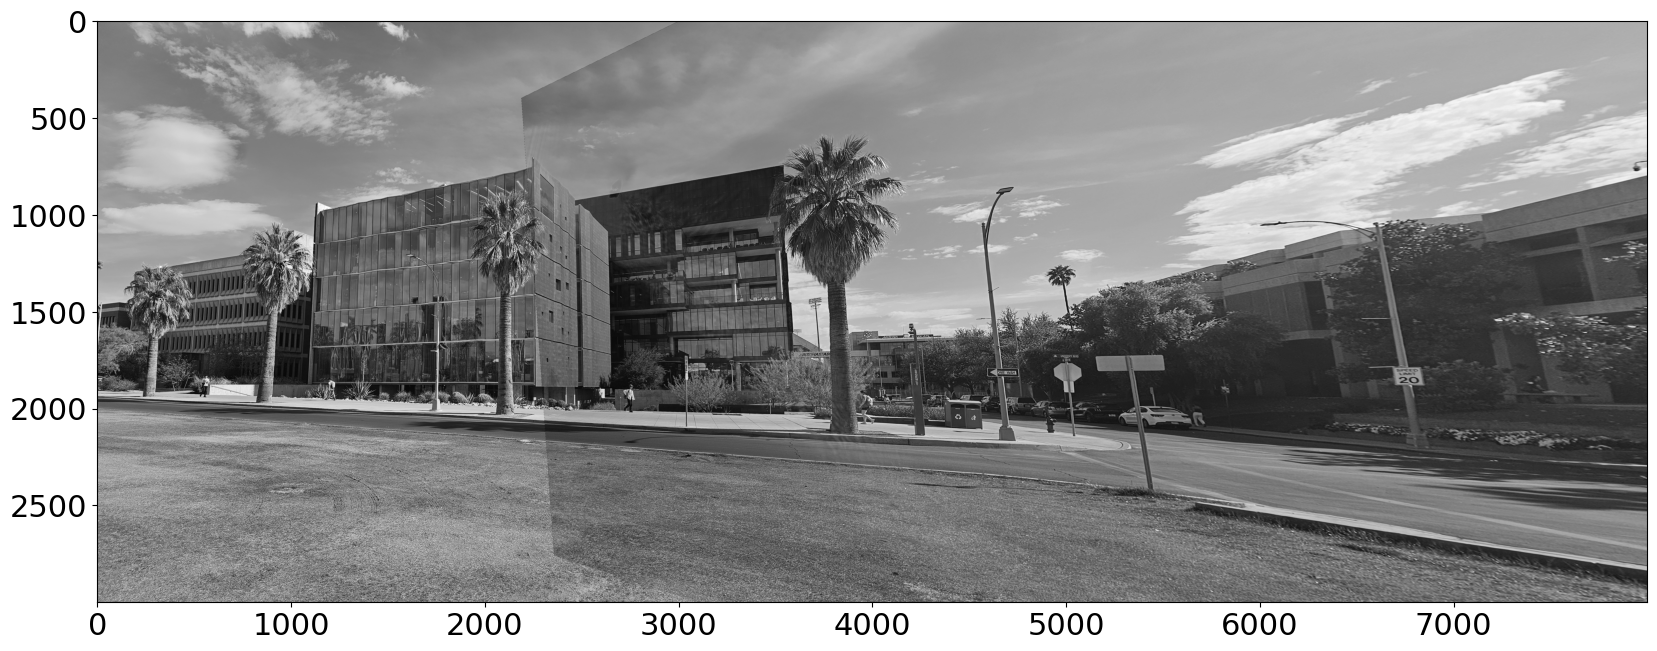

In [18]:
for i in range(image2.shape[0]):
    for j in range(image2.shape[1]):
        if warpImage[i,j] == 0:
            warpImage[i,j] = img2[i,j]
plt.imshow(warpImage, cmap='gray')